In [18]:
import torch
import torch.nn as nn
import os
import sys
import numpy as np
import argparse
import yaml
from matplotlib import pyplot as plt
sys.path.append('../dsc/')
sys.path.append("../..")
sys.path.append("../../tslib/src/")
sys.path.append("../../tslib/")
sys.path.append(os.getcwd())
from dsc_model import DSCModel
from bert2bert import Bert2BertSynCtrl
from transformers import BertConfig
from src import tsUtils
import pandas as pd
from src.synthcontrol.syntheticControl import RobustSyntheticControl
from src.synthcontrol.multisyntheticControl import MultiRobustSyntheticControl
SAVE_FIGS = True
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Fitting California
datapath = f'../datasets/prop99/'
config_path = '../exp_configs/prop99/config.yaml'
config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
op_path = f'../logs_dir/prop99/'
if not(os.path.exists(op_path)):
    os.mkdir(op_path)
random_seed = 0
target_index = 2
interv_time = 18
lowrank = True
device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
classes = None
config_model = BertConfig(hidden_size = config['hidden_size'],
                        num_hidden_layers = config['n_layers'],
                        num_attention_heads = config['n_heads'],
                        intermediate_size = 4*config['hidden_size'],
                        vocab_size = 0,
                        max_position_embeddings = 0,
                        output_hidden_states = True,
                        )

config_model.add_syn_ctrl_config(K=config['K'],
                                pre_int_len=config['pre_int_len'],
                                post_int_len=config['post_int_len'],
                                feature_dim=config['feature_dim'],
                                time_range=config['time_range'],
                                seq_range=config['seq_range'],
                                cont_dim=config['cont_dim'],
                                discrete_dim=config['discrete_dim'],
                                classes = classes)
model = Bert2BertSynCtrl(config_model, random_seed)
model = model.to(device)
dscmodel = DSCModel(model,
                    config,
                    op_path,
                    target_index,
                    random_seed,
                    datapath,
                    device,
                    lowrank = True,
                    classes=None)
dscmodel.fit(interv_time)
op= dscmodel.predict(18)

Low rank conversion done
Pretraining model on donor units
Iteration:0	Loss_mean:0.5391343832015991	Loss_std:0.0
Iteration:100	Loss_mean:0.46424262090586127	Loss_std:0.45067758857855955
Iteration:200	Loss_mean:0.2376997055672109	Loss_std:0.1937480724074548
Iteration:300	Loss_mean:0.17330888960626908	Loss_std:0.1876679773862091
Iteration:400	Loss_mean:0.10608667895372491	Loss_std:0.10391938828582356
Iteration:500	Loss_mean:0.04916834101459244	Loss_std:0.059183355117531616
Iteration:600	Loss_mean:0.0391995424972265	Loss_std:0.04700025381937083
Iteration:700	Loss_mean:0.03043371581577958	Loss_std:0.06261071667795111
Iteration:800	Loss_mean:0.02068499011351378	Loss_std:0.025127918338643404
Iteration:900	Loss_mean:0.025055700491648167	Loss_std:0.030941008956407813
Iteration:1000	Loss_mean:0.01694364334641705	Loss_std:0.028684887212717527
Iteration:1100	Loss_mean:0.02081578716664808	Loss_std:0.037552713872394394
Iteration:1200	Loss_mean:0.016013892120245145	Loss_std:0.02614437317922041
Iterat

In [2]:
#RSC, mRSC predict
data_dir = f'../datasets/prop99/'
mask = np.load(data_dir+'mask.npy',allow_pickle=True)
data = np.load(data_dir+'data.npy',allow_pickle=True)
data[np.nonzero(mask)] = 0
prob_missing = np.sum(mask)/(data.shape[0]*data.shape[1]*data.shape[2])
TrainingEnd= 18

all_observations=[]
for i in range(data.shape[2]):
    all_observations.append(data[:,:,i])

N = all_observations[0].shape[0] -1
T = all_observations[0].shape[1]
print(N,T)
trainingDict_alls = [{} for i in range(data.shape[2])]
testDict_alls = [{} for i in range(data.shape[2])]



for i in range(0, N+1):
    for j in range(data.shape[2]):
        trainingDict_alls[j].update({str(i): all_observations[j][i, 0:TrainingEnd]})
        testDict_alls[j].update({str(i): all_observations[j][i, TrainingEnd:]})

keySeriesLabel = '2'
otherSeriesLabels = []
for ind in range(N+1):
    if str(ind)!=keySeriesLabel:
        otherSeriesLabels.append(str(ind))

# RSC analysis
singvals = 3
train_DF_alls = []
test_DF_alls = []
for j in range(data.shape[2]):
    train_DF_alls.append(pd.DataFrame(data=trainingDict_alls[j]))
    test_DF_alls.append(pd.DataFrame(data=testDict_alls[j]))


rscmodel = RobustSyntheticControl(keySeriesLabel, singvals, len(train_DF_alls[0]), probObservation=1.0, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)
rscmodel.fit(train_DF_alls[0])
predictionsRSC = rscmodel.predict(test_DF_alls[0])

####  multi RSC model (combined) --
relative_weights =[1.0]+[0 for i in range(data.shape[2]-1)]

# instantiate the model
mrscmodel = MultiRobustSyntheticControl(data.shape[2], relative_weights, keySeriesLabel, 38, len(train_DF_alls[0]), probObservation=1-prob_missing, svdMethod='numpy', otherSeriesKeysArray=otherSeriesLabels)

# fit
mrscmodel.fit([train_DF_alls[i] for i in range(data.shape[2])])

# predict
combinedPredictionsArray = mrscmodel.predict([test_DF_alls[i] for i in range(data.shape[2])])

# split the predictions for the metrics
predictionsmRSC = combinedPredictionsArray[0]
op_dir = f'../logs_dir/prop99/'
np.save(op_dir+'mrsc_pred.npy',predictionsmRSC)
np.save(op_dir+'rsc_pred.npy',predictionsRSC)
mrsc_pred = predictionsmRSC
rsc_pred = predictionsRSC
denoisedDF = rscmodel.model.denoisedDF()
rsc_pred_pre = denoisedDF[keySeriesLabel]
denoisedDF = mrscmodel.model.denoisedDF()
mrsc_pred_pre = denoisedDF[keySeriesLabel]

38 31


In [3]:
#Predict DSC

interv_time = 18
datapath = f'../datasets/prop99/'
config_path = '../exp_configs/prop99/config.yaml'
config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
op_path = f'../logs_dir/prop99/'
model_path = f'../logs_dir/prop99/finetune/model.pth'
if not(os.path.exists(op_path)):
    os.mkdir(op_path)
random_seed = 0
target_index = 2
lowrank = True
device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
classes = None
config_model = BertConfig(hidden_size = config['hidden_size'],
                        num_hidden_layers = config['n_layers'],
                        num_attention_heads = config['n_heads'],
                        intermediate_size = 4*config['hidden_size'],
                        vocab_size = 0,
                        max_position_embeddings = 0,
                        output_hidden_states = True,
                        )

config_model.add_syn_ctrl_config(K=config['K'],
                                pre_int_len=config['pre_int_len'],
                                post_int_len=config['post_int_len'],
                                feature_dim=config['feature_dim'],
                                time_range=config['time_range'],
                                seq_range=config['seq_range'],
                                cont_dim=config['cont_dim'],
                                discrete_dim=config['discrete_dim'],
                                classes = classes)
model = Bert2BertSynCtrl(config_model, random_seed)
model = model.to(device)
dscmodel = DSCModel(model,
                    config,
                    op_path,
                    target_index,
                    random_seed,
                    datapath,
                    device,
                    lowrank = True,
                    classes=None)
dscmodel.load_model_from_checkpoint(model_path)
op= dscmodel.predict(18)

Modifying K
Low rank conversion done


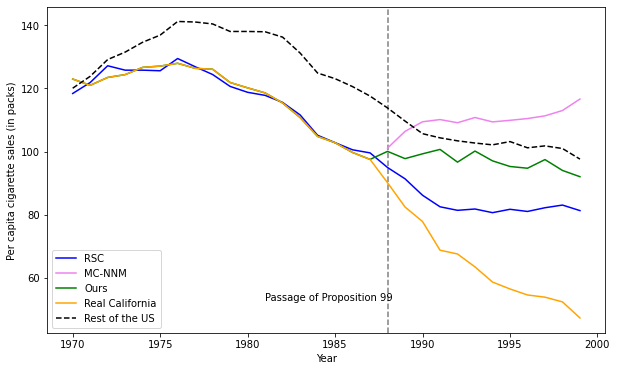

In [4]:
#Plot all
fig=plt.figure(figsize=(10,6))
mc_nnm = pd.read_csv('../datasets/prop99/mc_nnm_pred.csv', sep=',',header=None)
data = np.load(datapath+'data.npy',allow_pickle=True) 
rest = np.concatenate((data[:2,:,0],data[3:,:,0]),axis=0)
mean_rest = np.mean(rest,0)
ax = plt.gca()
trans = ax.get_xaxis_transform()
xrange = [i for i in range(1970,2001)]
xtick = [i for i in range(1970,2001,5)]
xlabel = [str(i) for i in range(1970,2001,5)]
trans = ax.get_xaxis_transform()
ax.set_xticks(xtick)
ax.set_xticklabels(xlabel)
mc_nnm = mc_nnm.to_numpy()[1:,].reshape(-1).astype('float32')
mc_nnm = np.flip(mc_nnm)
rsc_all = np.append(rsc_pred_pre,rsc_pred,axis=0)
mrsc_all = np.append(mrsc_pred_pre[:18],mrsc_pred,axis=0)
obs_all = np.append(trainingDict_alls[0][keySeriesLabel],testDict_alls[0][keySeriesLabel],axis=0)
plt.axvline(x = 1988,ymin=0, ymax =1 ,linestyle='--',color='black',alpha=0.5)
plt.plot(xrange[:-1],rsc_all[:-1],'b-',label='RSC')
#plt.plot(xrange[:-1],mrsc_all[:-1],'xkcd:maroon',label='mRSC')
plt.plot(xrange[-13:-1],mc_nnm[-13:-1],linestyle='-',color='violet',label='MC-NNM')
plt.plot(xrange[:-1],op[:-1],'g-',label='Ours')
plt.plot(xrange[:-1],obs_all[:-1],linestyle='-',color='orange',label='Real California')
plt.plot(xrange[:-1],mean_rest[:-1],linestyle='--',color='black',label='Rest of the US')

plt.xlabel('Year')
plt.ylabel('Per capita cigarette sales (in packs)')
plt.text(1981,0.1, 'Passage of Proposition 99',transform=trans)
plt.legend(loc='lower left')
plt.savefig(f'./figs/prop99.pdf',bbox_inches='tight')

In [23]:
print(op[-2]-obs_all[-2])
print(rsc_all[-2]-obs_all[-2])
print(mc_nnm[-2]-obs_all[-2])

45.58866577148437
34.06160202462736
69.450146484375


In [19]:
#Spatiotemporal weights
datapath = f'../datasets/prop99/'
config_path = '../exp_configs/prop99/config.yaml'
config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
op_path = f'../logs_dir/prop99/'
model_path = f'../logs_dir/prop99/finetune/model.pth'
if not(os.path.exists(op_path)):
    os.mkdir(op_path)
random_seed = 0
target_index = 2
interv_time = 18
lowrank = True
device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
classes = None
config_model = BertConfig(hidden_size = config['hidden_size'],
                        num_hidden_layers = config['n_layers'],
                        num_attention_heads = config['n_heads'],
                        intermediate_size = 4*config['hidden_size'],
                        vocab_size = 0,
                        max_position_embeddings = 0,
                        output_hidden_states = True,
                        )

config_model.add_syn_ctrl_config(K=config['K'],
                                pre_int_len=config['pre_int_len'],
                                post_int_len=config['post_int_len'],
                                feature_dim=config['feature_dim'],
                                time_range=config['time_range'],
                                seq_range=config['seq_range'],
                                cont_dim=config['cont_dim'],
                                discrete_dim=config['discrete_dim'],
                                classes = classes)
model = Bert2BertSynCtrl(config_model, random_seed)
model = model.to(device)
dscmodel = DSCModel(model,
                    config,
                    op_path,
                    target_index,
                    random_seed,
                    datapath,
                    device,
                    lowrank = True,
                    classes=None)
dscmodel.load_model_from_checkpoint(model_path)
attentions = dscmodel.return_attention(1)



Modifying K
Low rank conversion done


In [20]:
attentions = np.array(attentions)
attentions_all = [attentions[:,i].T for i in range(3)]
attentions_all.append(np.mean(attentions,1).T)

In [21]:
attentions_all[0].shape

(38, 30)

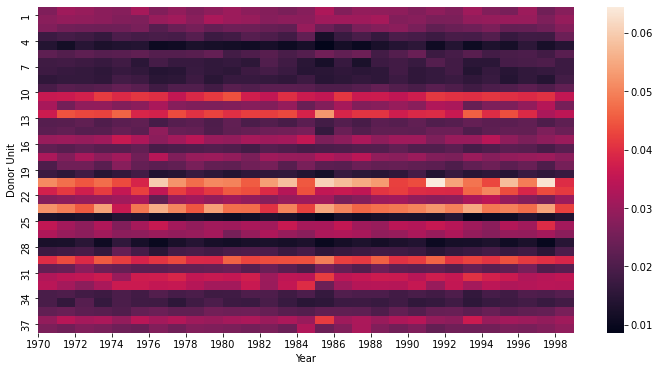

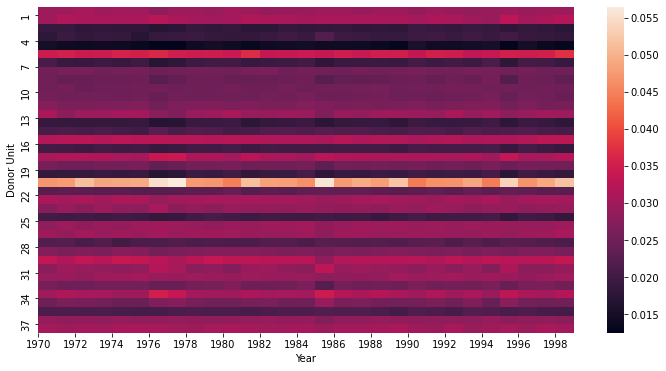

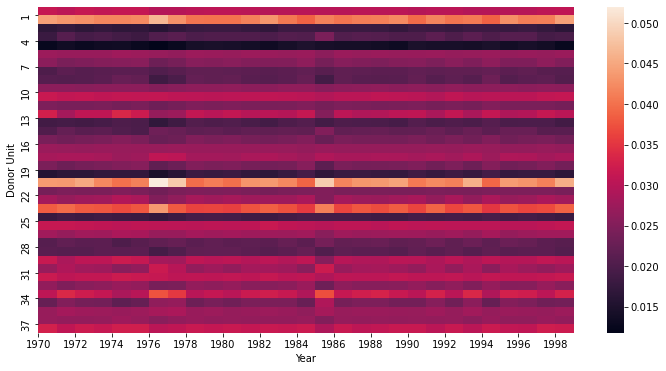

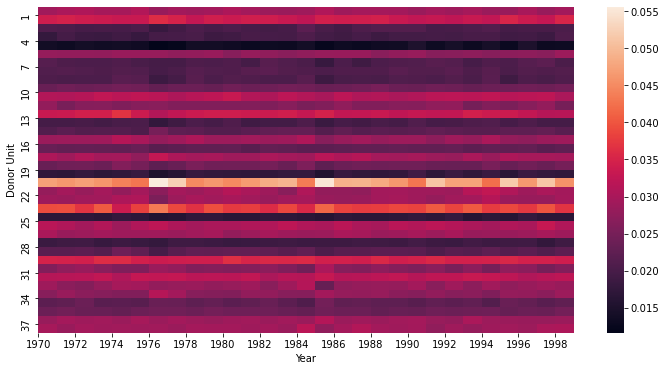

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt



for k in range(4):
    plt.figure(figsize = (12,6))
    xticks = [i for i in range(0,30,2)]
    yticks = [i for i in range(1,38,3)]
    xlabels = [str(i) for i in range(1970,2000,2)]
    ylabels = [str(i) for i in range(1,38,3)]
    ax = sns.heatmap(attentions_all[k][:,:-1],vmin=np.min(attentions_all[k][:,:-1]),vmax=np.max(attentions_all[k][:,:-1]))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_ylabel('Donor Unit')
    ax.set_xlabel('Year')

    if SAVE_FIGS:
        plt.savefig(f'./figs/weights_attention_{k}.pdf',bbox_inches='tight')

In [23]:
states = ['Alabama','Arkansas','Colorado','Connecticut','Delaware','Georgia','Idaho','Illinois',
 'Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Minnesota','Mississippi',
 'Missouri','Montana','Nebraska','Nevada','New Hampshire','New Mexico','North Carolina',
 'North Dakota','Ohio','Oklahoma','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont',
 'Virginia','West Virginia','Wisconsin','Wyoming']
for attentions in attentions_all:
    donor = np.sum(attentions,1)
    top_donors = (-donor).argsort()[:10].tolist()
    print(top_donors)

    print([states[i] for i in top_donors])

[20, 23, 29, 12, 21, 10, 31, 32, 25, 36]
['New Hampshire', 'North Dakota', 'South Dakota', 'Louisiana', 'New Mexico', 'Kansas', 'Texas', 'Utah', 'Oklahoma', 'Wisconsin']
[20, 5, 29, 15, 17, 33, 1, 37, 22, 0]
['New Hampshire', 'Georgia', 'South Dakota', 'Mississippi', 'Montana', 'Vermont', 'Arkansas', 'Wyoming', 'North Carolina', 'Alabama']
[20, 1, 23, 33, 37, 31, 25, 10, 0, 12]
['New Hampshire', 'Arkansas', 'North Dakota', 'Vermont', 'Wyoming', 'Texas', 'Oklahoma', 'Kansas', 'Alabama', 'Louisiana']
[20, 23, 29, 1, 12, 31, 10, 25, 17, 0]
['New Hampshire', 'North Dakota', 'South Dakota', 'Arkansas', 'Louisiana', 'Texas', 'Kansas', 'Oklahoma', 'Montana', 'Alabama']


In [ ]:
# Fitting Colorado --> APpendix
datapath = f'../datasets/prop99/'
config_path = '../exp_configs/prop99/config.yaml'
config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
op_path = f'../logs_dir/prop99/'
if not(os.path.exists(op_path)):
    os.mkdir(op_path)
random_seed = 0
target_index = 3
interv_time = 18
lowrank = True
device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
classes = None
config_model = BertConfig(hidden_size = config['hidden_size'],
                        num_hidden_layers = config['n_layers'],
                        num_attention_heads = config['n_heads'],
                        intermediate_size = 4*config['hidden_size'],
                        vocab_size = 0,
                        max_position_embeddings = 0,
                        output_hidden_states = True,
                        )

config_model.add_syn_ctrl_config(K=config['K'],
                                pre_int_len=config['pre_int_len'],
                                post_int_len=config['post_int_len'],
                                feature_dim=config['feature_dim'],
                                time_range=config['time_range'],
                                seq_range=config['seq_range'],
                                cont_dim=config['cont_dim'],
                                discrete_dim=config['discrete_dim'],
                                classes = classes)
model = Bert2BertSynCtrl(config_model, random_seed)
model = model.to(device)
dscmodel = DSCModel(model,
                    config,
                    op_path,
                    target_index,
                    random_seed,
                    datapath,
                    device,
                    lowrank = True,
                    classes=None)
dscmodel.fit(interv_time)
op_colorado = dscmodel.predict(18)

In [ ]:
# Fitting Iowa --> Appendix
datapath = f'../datasets/prop99/'
config_path = '../exp_configs/prop99/config.yaml'
config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
op_path = f'../logs_dir/prop99/'
if not(os.path.exists(op_path)):
    os.mkdir(op_path)
random_seed = 0
target_index = 10
interv_time = 18
lowrank = True
device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
classes = None
config_model = BertConfig(hidden_size = config['hidden_size'],
                        num_hidden_layers = config['n_layers'],
                        num_attention_heads = config['n_heads'],
                        intermediate_size = 4*config['hidden_size'],
                        vocab_size = 0,
                        max_position_embeddings = 0,
                        output_hidden_states = True,
                        )

config_model.add_syn_ctrl_config(K=config['K'],
                                pre_int_len=config['pre_int_len'],
                                post_int_len=config['post_int_len'],
                                feature_dim=config['feature_dim'],
                                time_range=config['time_range'],
                                seq_range=config['seq_range'],
                                cont_dim=config['cont_dim'],
                                discrete_dim=config['discrete_dim'],
                                classes = classes)
model = Bert2BertSynCtrl(config_model, random_seed)
model = model.to(device)
dscmodel = DSCModel(model,
                    config,
                    op_path,
                    target_index,
                    random_seed,
                    datapath,
                    device,
                    lowrank = True,
                    classes=None)
dscmodel.fit(interv_time)